In [1]:
# Cell 2 - imports and paths
# English comments inside code as requested.

import os
import re
import json
import math
from glob import glob
from tqdm.auto import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizerFast

# Paths - adjust if needed
ROOT = "/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa"
MODEL_DIR = os.path.join(ROOT, "models", "SeyedAli-Persian-Text-Emotion-Bert-V1")
DATA_DIR = os.path.join(ROOT, "data")
OUTPUT_DIR = os.path.join(DATA_DIR, "sentiment_results_batch")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/mdvr0480/Public/ANLP/ai-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Cell 3 - labels and helper functions

# Emotion labels as required by the assignment
EMOTION_LABELS = ["Happy", "Sad", "Angry", "Worried", "Anxious", "Neutral"]

def softmax(x):
    """Simple softmax for numpy array / torch tensor"""
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    e = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e / e.sum(axis=-1, keepdims=True)

In [3]:
# Cell 4 - text cleaning functions (English comments)

# Try to use hazm Normalizer if available for better Persian normalization
try:
    from hazm import Normalizer
    hazm_normalizer = Normalizer()
except Exception:
    hazm_normalizer = None
    print("hazm not available or failed to import - will use regex fallback normalizer")

# Regex patterns
URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_TAG_RE = re.compile(r"<[^>]+>")
EMOJI_RE = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)

def basic_persian_normalize(text: str) -> str:
    """
    Basic normalization for Persian text:
    - remove HTML, URLs, emojis
    - remove extra whitespace
    - optionally use hazm Normalizer for advanced normalization
    """
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r'\u200c', ' ', t)  # ZWNJ -> space
    t = URL_RE.sub(' ', t)
    t = HTML_TAG_RE.sub(' ', t)
    t = EMOJI_RE.sub(' ', t)
    # remove non-printable/control
    t = re.sub(r'[\r\n\t]+', ' ', t)
    # remove numbers and excessive punctuation (but keep basic punctuation)
    t = re.sub(r'[0-9۰-۹]+', ' ', t)
    # remove redundant punctuation (more than 2)
    t = re.sub(r'([!?.,؛،])\1+', r'\1', t)
    # remove other symbols
    t = re.sub(r'[^آابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهیءًٌٍَُِْٔٔٔ\s\.\,\?\!\،\؛\-]', ' ', t)
    # collapse spaces
    t = re.sub(r'\s+', ' ', t).strip()
    # hazm normalization if available
    if hazm_normalizer:
        try:
            t = hazm_normalizer.normalize(t)
        except Exception:
            pass
    return t

In [4]:
# Cell 5 - read CSVs from data directory and concat them
# We assume message column contains the post text.
csv_files = sorted(glob(os.path.join(DATA_DIR, "*_messages.csv")))
print("Found CSV files:", csv_files)

dfs = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp)
        df["__source_file"] = os.path.basename(fp)
        dfs.append(df)
    except Exception as e:
        print("Failed to read", fp, e)

if len(dfs) == 0:
    raise RuntimeError("No CSVs loaded - check DATA_DIR and file patterns.")

raw_df = pd.concat(dfs, ignore_index=True, sort=False)
print("Raw dataframe shape:", raw_df.shape)

# Save a copy of raw merged data
raw_out = os.path.join(OUTPUT_DIR, "raw_historical_posts.csv")
raw_df.to_csv(raw_out, index=False)
print("Saved raw merged CSV to", raw_out)

Found CSV files: ['/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/TweetyChannel_messages.csv', '/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/bbcpersian_messages.csv', '/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/iranintlTV_messages.csv', '/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/kafiha_messages.csv', '/media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/radiofarda_messages.csv']
Raw dataframe shape: (942708, 8)
Saved raw merged CSV to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/raw_historical_posts.csv


In [5]:
# Cell 6 - apply preprocessing
# We'll create clean_post_text and (if reactions column exists) clean_reactions

# Identify possible text columns
text_cols = []
for col in ["message", "post_text", "text", "content"]:
    if col in raw_df.columns:
        text_cols.append(col)
# choose first available text column
if len(text_cols) == 0:
    # fallback: try to guess any column with many string values
    for c in raw_df.columns:
        if raw_df[c].dtype == object and raw_df[c].astype(str).str.len().mean() > 10:
            text_cols.append(c)
            break

text_col = text_cols[0] if text_cols else None
print("Using text column:", text_col)

def safe_get_date(df):
    # try multiple column names for timestamp
    for c in ["date", "timestamp", "created_at", "time"]:
        if c in df.columns:
            try:
                dt = pd.to_datetime(df[c], errors="coerce")
                return dt.rename("date")
            except:
                continue
    return pd.Series([pd.NaT]*len(df), name="date")

raw_df["clean_post_text"] = raw_df[text_col].fillna("").astype(str).map(basic_persian_normalize)

# reactions: if present, collapse to string and clean
reaction_cols = [c for c in ["reactions", "comments", "reply_text", "replies"] if c in raw_df.columns]
if reaction_cols:
    raw_df["raw_reactions"] = raw_df[reaction_cols].astype(str).agg(" || ".join, axis=1)
    raw_df["clean_reactions"] = raw_df["raw_reactions"].map(basic_persian_normalize)
else:
    raw_df["raw_reactions"] = ""
    raw_df["clean_reactions"] = ""

# attach parsed date
raw_df["date"] = safe_get_date(raw_df)

# Save preprocessed CSV
processed_out = os.path.join(OUTPUT_DIR, "preprocessed_posts.csv")
raw_df.to_csv(processed_out, index=False)
print("Saved preprocessed CSV to", processed_out)

Using text column: text
Saved preprocessed CSV to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/preprocessed_posts.csv


In [ ]:
# Cell 6.5 - Process Emoji Reactions

def parse_emoji_reactions(reaction_str):
    if not isinstance(reaction_str, str) or not reaction_str:
        return {'positive': 0, 'negative': 0, 'total': 0}

    positive_emojis = ['👍', '❤️', '🔥', '🎉', '👏', '🤩', '💯', '⭐']
    negative_emojis = ['👎', '😢', '😡', '🤮']
    
    positive_count = 0
    negative_count = 0
    total_count = 0
    
    try:
        reactions = reaction_str.split(', ')
        for r in reactions:
            emoji, count_str = r.split(':')
            count = int(count_str)
            total_count += count
            if emoji in positive_emojis:
                positive_count += count
            elif emoji in negative_emojis:
                negative_count += count
    except Exception:
        # Handle potential parsing errors if format is unexpected
        return {'positive': 0, 'negative': 0, 'total': 0}
        
    return {'positive': positive_count, 'negative': negative_count, 'total': total_count}

# Apply the function to the emoji_reactions column
# The 'final' dataframe is created later, so we apply it to 'raw_df'
if 'emoji_reactions' in raw_df.columns:
    reaction_counts = raw_df['emoji_reactions'].apply(parse_emoji_reactions)
    reaction_df = pd.DataFrame(reaction_counts.tolist())
    
    # Add new columns to the main dataframe
    raw_df['positive_reactions'] = reaction_df['positive']
    raw_df['negative_reactions'] = reaction_df['negative']
    raw_df['total_reactions'] = reaction_df['total']
    
    print("Emoji reaction counts processed and added as new columns.")
else:
    print("No 'emoji_reactions' column found. Skipping emoji processing.")

In [6]:
# Cell 7 - load model and tokenizer from local path
# We will use AutoTokenizer and AutoModelForSequenceClassification.
# The model is expected to have num_labels = 6. If not, we'll still proceed but warn.

# Use the slow tokenizer to avoid AttributeError
tokenizer = BertTokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)

# Move model to the device (GPU/CPU)
model.to(device)
model.eval()

# Check number of labels in the model and compare with predefined EMOTION_LABELS
print("Model loaded. Num labels:", model.config.num_labels)
if model.config.num_labels != len(EMOTION_LABELS):
    print("WARNING: model.num_labels != len(EMOTION_LABELS). Make sure label order matches training.")

2025-11-13 17:57:13.094290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 17:57:13.185007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 17:57:14.565470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Model loaded. Num labels: 6


In [7]:
# Cell 8 - batched prediction
def predict_texts(texts, batch_size=32, max_length=256):
    """
    Predict emotion probabilities for a list of texts.
    Returns list of dicts: {label:score,...} for each text (labels in EMOTION_LABELS order).
    """
    results = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Predicting batches"):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            logits = out.logits  # shape (batch, num_labels)
            probs = F.softmax(logits, dim=-1).detach().cpu().numpy()
        for p in probs:
            # ensure mapping to our EMOTION_LABELS
            d = {EMOTION_LABELS[j]: float(p[j]) for j in range(min(len(EMOTION_LABELS), p.shape[0]))}
            results.append(d)
    return results

In [8]:
# Cell 9 - run predictions on clean_post_text
texts = raw_df["clean_post_text"].fillna("").tolist()
pred_probs = predict_texts(texts, batch_size=64, max_length=256)

# Build dataframe of predictions
pred_df = pd.DataFrame(pred_probs)
# choose top label
pred_df["pred_label"] = pred_df[EMOTION_LABELS].idxmax(axis=1)
# combine with original dataframe
final = pd.concat([raw_df.reset_index(drop=True), pred_df.reset_index(drop=True)], axis=1)

# Save detailed results (includes probabilities for each label)
final_out = os.path.join(OUTPUT_DIR, "sentiment_results_6labels_detailed.csv")
final.to_csv(final_out, index=False)
print("Saved prediction results to", final_out)

Predicting batches:   3%|▎         | 508/14730 [10:13<4:46:12,  1.21s/it]


KeyboardInterrupt: 

Saved monthly counts to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/monthly_emotion_counts.csv


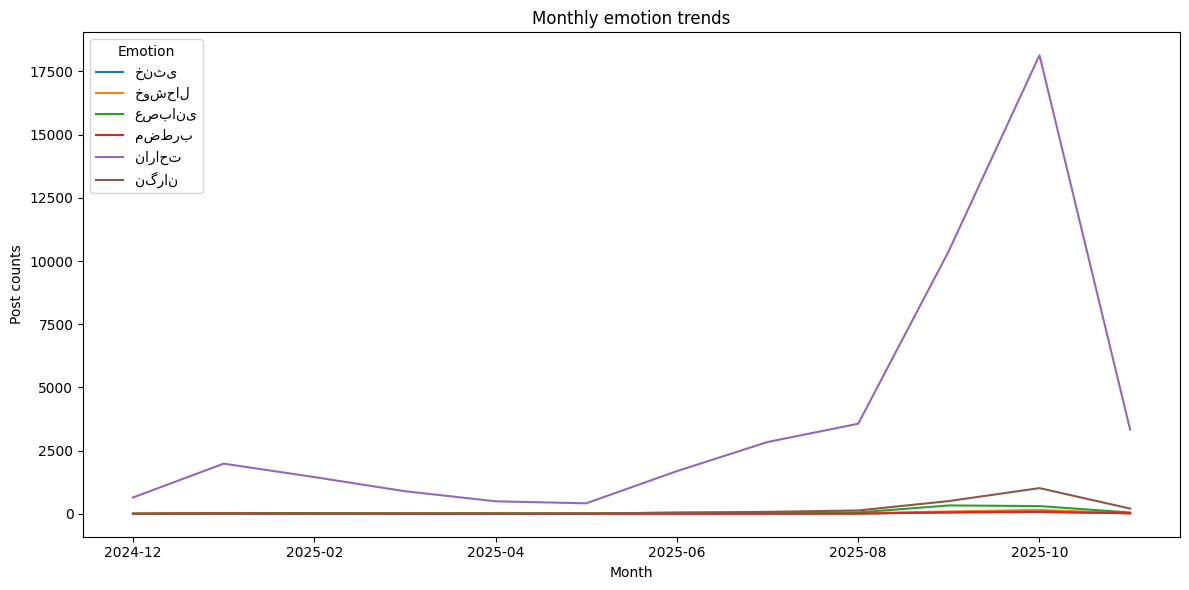

Saved yearly counts to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/yearly_emotion_counts.csv


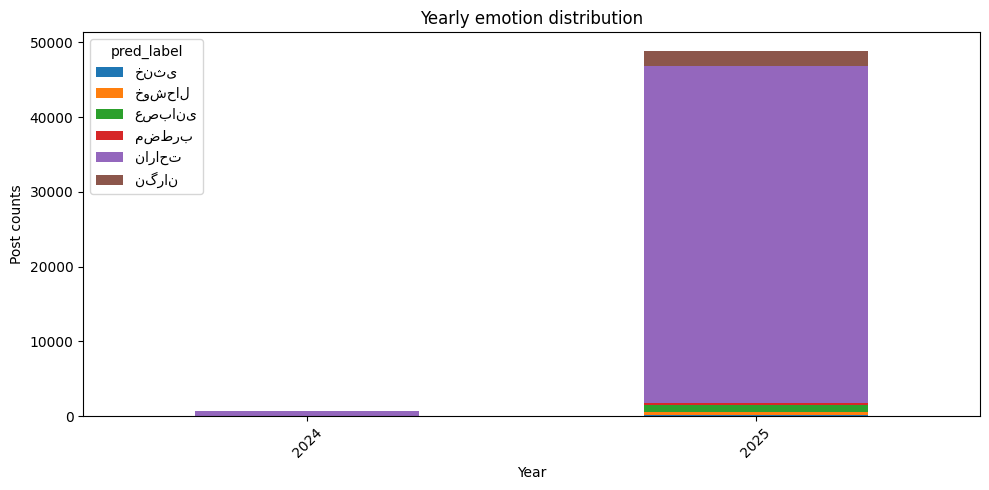

In [14]:
# Cell 10 - time series aggregation and plots

# ensure date column is datetime (FIXED the mismatched quotes)
final["date"] = pd.to_datetime(final["date"], errors="coerce")

# If date exists, aggregate monthly and yearly trends
if final["date"].notna().sum() > 0:
    # monthly
    final["month"] = final["date"].dt.to_period("M")
    monthly = final.groupby(["month", "pred_label"]).size().unstack(fill_value=0)
    monthly.index = monthly.index.astype(str)
    monthly_out = os.path.join(OUTPUT_DIR, "monthly_emotion_counts.csv")
    monthly.to_csv(monthly_out)
    print("Saved monthly counts to", monthly_out)

    # plot monthly trends (line plot) - Removed redundant plt.figure()
    monthly.plot(figsize=(12,6))
    plt.title("Monthly emotion trends")
    plt.xlabel("Month")
    plt.ylabel("Post counts")
    plt.legend(title="Emotion")
    plt.tight_layout()
    plt.show()

    # yearly
    final["year"] = final["date"].dt.to_period("Y")
    yearly = final.groupby(["year", "pred_label"]).size().unstack(fill_value=0)
    yearly_out = os.path.join(OUTPUT_DIR, "yearly_emotion_counts.csv")
    yearly.to_csv(yearly_out)
    print("Saved yearly counts to", yearly_out)

    # plot yearly trends (stacked bar plot) - Removed redundant plt.figure()
    yearly.plot(kind="bar", stacked=True, figsize=(10,5))
    plt.title("Yearly emotion distribution")
    plt.xlabel("Year")
    plt.ylabel("Post counts")
    plt.xticks(rotation=45) # Added for better label readability
    plt.tight_layout()
    plt.show()
else:
    print("No valid date column found; skipping time-series aggregation.")

In [ ]:
# Cell 11 - per source (based on __source_file or any 'source' column)
source_col = "__source_file" if "__source_file" in final.columns else ("source" if "source" in final.columns else None)
if source_col:
    per_source = final.groupby([source_col, "pred_label"]).size().unstack(fill_value=0)
    per_source_out = os.path.join(OUTPUT_DIR, "per_source_emotion_counts.csv")
    per_source.to_csv(per_source_out)
    print("Saved per-source emotion counts to", per_source_out)
else:
    print("No source column found. You can set a source column to get per-platform stats.")

Saved per-source emotion counts to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/per_source_emotion_counts.csv


In [ ]:
# Cell 12 - exports and simple QA
# top example posts for each label (for manual inspection)
examples = {}
for label in EMOTION_LABELS:
    subset = final[final["pred_label"] == label]
    examples[label] = subset[["clean_post_text", "raw_reactions", "date"]].head(10)

# Save examples in a JSON file for quick review
examples_out = os.path.join(OUTPUT_DIR, "top_examples_per_label.json")
# convert datetimes to string for JSON
def to_serializable(df):
    d = df.copy()
    if "date" in d.columns:
        d["date"] = d["date"].astype(str)
    return d.to_dict(orient="records")

json_examples = {k: to_serializable(v) for k,v in examples.items()}
with open(examples_out, "w", encoding="utf-8") as f:
    json.dump(json_examples, f, ensure_ascii=False, indent=2)
print("Saved example posts per label to", examples_out)

Saved example posts per label to /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/top_examples_per_label.json


In [ ]:
# Cell 13 - short reproducibility notes (printed)
print("""
REPRODUCIBILITY NOTES:
- Model dir: {}
- Raw merged CSV: {}
- Preprocessed CSV: {}
- Detailed predictions: {}
- Monthly/yearly: {} , {}
- Examples per label: {}
Make sure model.label order matches EMOTION_LABELS defined in the notebook.
""".format(MODEL_DIR, raw_out, processed_out, final_out, monthly_out if 'monthly_out' in globals() else 'N/A', yearly_out if 'yearly_out' in globals() else 'N/A', examples_out))


REPRODUCIBILITY NOTES:
- Model dir: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/models/SeyedAli-Persian-Text-Emotion-Bert-V1
- Raw merged CSV: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/raw_historical_posts.csv
- Preprocessed CSV: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/preprocessed_posts.csv
- Detailed predictions: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/sentiment_results_6labels_detailed.csv
- Monthly/yearly: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/monthly_emotion_counts.csv , /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/yearly_emotion_counts.csv
- Examples per label: /media/mdvr0480/Data/Uni/Term1/ANLP/telegram-sentiment-analysis-fa/data/sentiment_results_batch/top_examples_per_label.json
Mak